<a href="https://colab.research.google.com/github/ekalmes/Portfolio/blob/main/Zeke_Kalmes_12_0_2_5_Classification_Logistic_Regression_w_Imbalanced_Classes_Exercise_Adult_Income.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise - Logistic Regression - Adult Income
by Zeke Kalmes and Brad Sheese

* Create a notebook that uses logistic regression to examine predictors of adult income (Over 50k, Under 50k)
* Begin by building a notebook that retrievs the data from the data source below
* The data has been split into two files (test and train), get the data from both files, clean up the data then combine them back into a single file. We will create out own test and train data sets. 
* Use skLearn with model cross-validation
* Do not specify a solver
* Use the pandas `pd.get_dummies()` function to one hot encode features
* Do not one hot encode binary features into two separate features
* Normalize all continous predictors
* Create a reduced model that has best results you can get with seven or fewer features
* State your conlusion at the end of your notebook (bullet points are fine)








In [ ]:
#@title Getting started? Execute this cell first.
#@markdown Click on the arrow to the left to execute this cell.

# set exercise name here
exercise_name = '12.0.2.5 LogRegress Imbalanced - Adult Income'

import os
import sys
import math

tool_path = '/content/cs125_tools/'

if not os.path.exists(tool_path):
  ! git clone --quiet https://github.com/bsheese/cs125_tools.git

if tool_path not in sys.path:
  sys.path.append(tool_path)

import exercise_report_response

exercise_report_response.exercise_time_difficulty_report(exercise_name)

Done!


## Data Source

The data is [hosted at UCI](https://archive.ics.uci.edu/ml/datasets/adult).
*   [Folder: Data files](https://archive.ics.uci.edu/ml/machine-learning-databases/adult/)




---




## Imports and Data


### Library Imports

In [ ]:
%%capture
!pip install pingouin

In [ ]:
# enter and test your code here
import pingouin as pg
import pandas as pd
import seaborn as sns
from matplotlib import style
import matplotlib.pyplot as plt
import urllib.request as request
import numpy as np 

from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score

import statsmodels.api as sm

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Helper Functions
These functions were provided by Prof. Sheese in previous exercises. 

In [ ]:
def print_parameter_coefficients(parameter_estimates):
  '''
  takes a fitted model and set of features (X)
  prints model parameter coefficients
  '''
  print('The parameter coefficients are:\n')

  for a in parameter_estimates:
    coefficient = round(a[1], 4)
    print(f'\t{a[0]}: {coefficient}')
  print()

def print_classification_report(predictions, y_test):
  '''
  prints classifications report of predictions
  takes fitted model, X_test and y_test
  '''
  # classification report
  print('\nClassification Report:\n')
  print(classification_report(y_test, predictions))
  print()

def print_confusion_matrix(y_test, predictions, condition1, condition2):
  # confusion matrix
  c_matrix = confusion_matrix(y_test, predictions)
  print('Confusion Matrix:\n')
  print('\tOur logistic regression model predicted the following when applied to the test data:\n')
  print(f'\tIt correctly predicted {c_matrix[0][0]} of {c_matrix[0][0] + c_matrix[0][1]} {condition1}, \n \
          but incorrectly predicted {c_matrix[0][1]} {condition1} that did not occur.\n')
  print(f'\tIt correctly predicted {c_matrix[1][1]} of {c_matrix[1][0] + c_matrix[1][1]} {condition2}, \n \
          but incorrectly predicted {c_matrix[1][0]} {condition2} that did not occur.\n')
  

  
def print_model_reports(logmodel, predictions, y_test, condition1, condition2,
                        parameter_report=False,
                        odds_ratio_report=True):
  
  #print accuracy
  accuracy = accuracy_score(y_test, predictions)
  print('Prediction accuracy: ', accuracy)
  
  # report y intercept 
  print(f'The y-intercept of our model is {logmodel.intercept_[0].round(4)}')
  print()

  # print parameters, classification report, confusion matrix
  if parameter_report == True:
    print_parameter_coefficients(parameter_estimates)
  print_classification_report(predictions, y_test)
  print_confusion_matrix(y_test, predictions, condition1, condition2)

  #print odds ratios
  if odds_ratio_report == True:
    print('The odds ratios are:')
    for a in parameter_estimates:
      oddsratio = np.exp(a[1]).round(2)
      print(f'{a[0]}: {oddsratio}')

### Data Import and Manipulation

In [ ]:
# imports and functions for authenticating google account
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#id of train file in google drive
file_id = '1lf-oMxJXfMRCHsyKRGWWRbXdZzesHujo'
downloaded = drive.CreateFile({'id': file_id})

test_id = '1xVVjx0bI0YjiWJ9p_YmE0EZBd2jYO3og'
downloaded2 = drive.CreateFile({'id': test_id})


In [ ]:
#user must download files into notebook 
downloaded.GetContentFile('adult.data')
downloaded2.GetContentFile('adult.test')

In [ ]:
!ls -lha adult.data

-rw-r--r-- 1 root root 3.8M Nov 30 00:39 adult.data


In [ ]:
!ls -lha adult.test

-rw-r--r-- 1 root root 2.0M Nov 30 00:39 adult.test


In [ ]:
# import the training and test datasets
df_adultdata = pd.read_csv('adult.data', sep=',', header=None)
df_adulttest = pd.read_csv('adult.test', sep=',', header=None, skiprows=1)

#concat these, ignore the index
df = pd.concat([df_adultdata, df_adulttest], ignore_index=True)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


Need to rename columns, as they were not inherited in the import. 

In [ ]:
df.columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       48842 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   education-num   48842 non-null  int64 
 5   marital-status  48842 non-null  object
 6   occupation      48842 non-null  object
 7   relationship    48842 non-null  object
 8   race            48842 non-null  object
 9   sex             48842 non-null  object
 10  capital-gain    48842 non-null  int64 
 11  capital-loss    48842 non-null  int64 
 12  hours-per-week  48842 non-null  int64 
 13  native-country  48842 non-null  object
 14  income          48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


No null's are present, so don't need to drop any nulls. Prof. Sheese recommended dropping the fnlwgt column as well as duplicate rows, so that will be done now. 

In [ ]:
df = df.drop(columns='fnlwgt')
df = df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44355 entries, 0 to 48841
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             44355 non-null  int64 
 1   workclass       44355 non-null  object
 2   education       44355 non-null  object
 3   education-num   44355 non-null  int64 
 4   marital-status  44355 non-null  object
 5   occupation      44355 non-null  object
 6   relationship    44355 non-null  object
 7   race            44355 non-null  object
 8   sex             44355 non-null  object
 9   capital-gain    44355 non-null  int64 
 10  capital-loss    44355 non-null  int64 
 11  hours-per-week  44355 non-null  int64 
 12  native-country  44355 non-null  object
 13  income          44355 non-null  object
dtypes: int64(5), object(9)
memory usage: 5.1+ MB


As we can see, this dropped just over 4000 duplicate rows, and also got rid of the fnlwgt column. Also, there were unnecessary periods in the income column of one of the df, so these need to be removed. 

In [ ]:
df['income'] = df['income'].str.rstrip('.') # https://stackoverflow.com/questions/37001787/remove-ends-of-string-entries-in-pandas-dataframe-column

Now, we need to look at the number of unique values for each column. 

In [ ]:
df.nunique()

age                74
workclass           9
education          16
education-num      16
marital-status      7
occupation         15
relationship        6
race                5
sex                 2
capital-gain      123
capital-loss       99
hours-per-week     96
native-country     42
income              2
dtype: int64

The variables with only 2 unique values (sex, income) need to be binary encoded. 

In [ ]:
sex_num = {' Male': 0, ' Female': 1} 
income_num = {' <=50K': 0, ' >50K': 1}

This creates new variables, now need to map these variables to their respective columns. These will replace the values that are already there. 

In [ ]:
df.sex = [sex_num[i] for i in df.sex]  # changing male to 0 and female to 1 
df.income = [income_num[i] for i in df.income] # changing <=50k to 0 and >50k to 1

In [ ]:
df.head(10)

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,0,2174,0,40,United-States,0
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,0,0,0,13,United-States,0
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,0,0,0,40,United-States,0
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,0,0,0,40,United-States,0
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,1,0,0,40,Cuba,0
5,37,Private,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,1,0,0,40,United-States,0
6,49,Private,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,1,0,0,16,Jamaica,0
7,52,Self-emp-not-inc,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,0,0,0,45,United-States,1
8,31,Private,Masters,14,Never-married,Prof-specialty,Not-in-family,White,1,14084,0,50,United-States,1
9,42,Private,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,0,5178,0,40,United-States,1


We can now see that the sex and income columns are binary encoded. Now it's time to reduce some of the other categoricals to have a smaller amount of values to dummy encode. We'll start with workclass. 

In [ ]:
df['workclass'].unique()

array([' State-gov', ' Self-emp-not-inc', ' Private', ' Federal-gov',
       ' Local-gov', ' ?', ' Self-emp-inc', ' Without-pay',
       ' Never-worked'], dtype=object)

We can combine all of the government job types into just government workers, can make a single unemployment value, and can make a single self-employed value

In [ ]:
def job_types(value):
  if value == ' State-gov' or value == ' Local-gov' or value == ' Federal-gov':
    value = 'Gov-employed'
    return value
  elif value == ' Never-worked' or value == ' Without-pay':
    value = 'Unemployed'
    return value
  elif value == ' Self-emp-not-inc' or value == ' Self-emp-inc':
    value = 'Self-employed'
    return value
  else:
    return value #returns private
df['workclass-category'] = df['workclass'].map(job_types)  # recreating the workclass column with less categoricals
df['workclass-category']

0         Gov-employed
1        Self-employed
2              Private
3              Private
4              Private
             ...      
48837          Private
48838                ?
48839          Private
48840          Private
48841    Self-employed
Name: workclass-category, Length: 44355, dtype: object

With workclass done, it's time to move onto native country. We will split this by USA and non-USA.

In [ ]:
def USA_born(value):
  if value == ' United-States':
    value = 1
    return value
  else:
    value = 'Non-US'
    return 0


df['native-country'] = df['native-country'].map(USA_born)  # recreating the native-country column with less categoricals
df['native-country']

0        1
1        1
2        1
3        1
4        0
        ..
48837    1
48838    1
48839    1
48840    1
48841    1
Name: native-country, Length: 44355, dtype: int64

With native-country done, it's time to move onto marital-status. This will be split by married, not married, and never married. 

In [ ]:
def marriage_status(value):
  if value == ' Separated' or value == ' Widowed' or value == ' Divorced':
    value = 'Not-married'
    return value
  elif value == ' Never-married':
    value = 'Never-married'
    return value
  else:
    value = 'Married'
    return value

df['marital-status'] = df['marital-status'].map(marriage_status)
df[df['marital-status'] == 'Not-married']

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income,workclass-category
2,38,Private,HS-grad,9,Not-married,Handlers-cleaners,Not-in-family,White,0,0,0,40,1,0,Private
19,43,Self-emp-not-inc,Masters,14,Not-married,Exec-managerial,Unmarried,White,1,0,0,45,1,1,Self-employed
21,54,Private,HS-grad,9,Not-married,Other-service,Unmarried,Black,1,0,0,20,1,0,Private
24,59,Private,HS-grad,9,Not-married,Tech-support,Unmarried,White,1,0,0,40,1,0,Private
28,39,Private,HS-grad,9,Not-married,Exec-managerial,Not-in-family,White,0,0,0,80,1,0,Private
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48829,58,Private,Assoc-acdm,12,Not-married,Prof-specialty,Not-in-family,White,0,0,0,36,1,0,Private
48835,48,Local-gov,Masters,14,Not-married,Other-service,Not-in-family,White,0,0,0,40,1,0,Gov-employed
48837,39,Private,Bachelors,13,Not-married,Prof-specialty,Not-in-family,White,1,0,0,36,1,0,Private
48838,64,?,HS-grad,9,Not-married,?,Other-relative,Black,0,0,0,40,1,0,?


With marital-status, done, it's time to move onto education. We will use the education-num column to categorize the education column. We will group hs-grads into some-college for less confusion. 

In [ ]:
def cat_education(value):
  if value in (' 11th', ' 9th', ' 7th-8th', ' 5th-6th', ' 10th', ' 1st-4th', ' 12th', ' Preschool', ' Prof-school'):
    value = 'No-highschool-grad'
    return value
  elif value in (' HS-grad', ' Some-college', ' Assoc-acdm', ' Assoc-voc'):
    value = 'Some-college'
    return value
  else:
    value = 'Higher-education'
    return value

df['education'] = df['education'].map(cat_education)
df.head()

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income,workclass-category
0,39,State-gov,Higher-education,13,Never-married,Adm-clerical,Not-in-family,White,0,2174,0,40,1,0,Gov-employed
1,50,Self-emp-not-inc,Higher-education,13,Married,Exec-managerial,Husband,White,0,0,0,13,1,0,Self-employed
2,38,Private,Some-college,9,Not-married,Handlers-cleaners,Not-in-family,White,0,0,0,40,1,0,Private
3,53,Private,No-highschool-grad,7,Married,Handlers-cleaners,Husband,Black,0,0,0,40,1,0,Private
4,28,Private,Higher-education,13,Married,Prof-specialty,Wife,Black,1,0,0,40,0,0,Private


Here we'll look at occupation and see if there's a way to collapse it. 

In [ ]:
df['occupation'].unique()

array([' Adm-clerical', ' Exec-managerial', ' Handlers-cleaners',
       ' Prof-specialty', ' Other-service', ' Sales', ' Craft-repair',
       ' Transport-moving', ' Farming-fishing', ' Machine-op-inspct',
       ' Tech-support', ' ?', ' Protective-serv', ' Armed-Forces',
       ' Priv-house-serv'], dtype=object)

All of these are relatively different, so there's no good way to further categorize them. Next, the relationship column. The best way to handle this one is to collapse based on whether or not the people are alone (0) or within a family (1).

In [ ]:
def rel_change(value):
  if value in (' Not-in-family', ' Unmarried'):
    value = 0
    return value
  else:
    value = 1
    return value

df['relationship'] = df['relationship'].map(rel_change)
df.head()

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income,workclass-category
0,39,State-gov,Higher-education,13,Never-married,Adm-clerical,0,White,0,2174,0,40,1,0,Gov-employed
1,50,Self-emp-not-inc,Higher-education,13,Married,Exec-managerial,1,White,0,0,0,13,1,0,Self-employed
2,38,Private,Some-college,9,Not-married,Handlers-cleaners,0,White,0,0,0,40,1,0,Private
3,53,Private,No-highschool-grad,7,Married,Handlers-cleaners,1,Black,0,0,0,40,1,0,Private
4,28,Private,Higher-education,13,Married,Prof-specialty,1,Black,1,0,0,40,0,0,Private


Last but not least, we will condense the race column. To simply things, it will be white (0) and minority (1). 

In [ ]:
def cat_race(value):
  if value == ' White':
    return 0
  else:
    value = 'Minority'
    return 1

df['race'] = df['race'].map(cat_race)
df.head()

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income,workclass-category
0,39,State-gov,Higher-education,13,Never-married,Adm-clerical,0,0,0,2174,0,40,1,0,Gov-employed
1,50,Self-emp-not-inc,Higher-education,13,Married,Exec-managerial,1,0,0,0,0,13,1,0,Self-employed
2,38,Private,Some-college,9,Not-married,Handlers-cleaners,0,0,0,0,0,40,1,0,Private
3,53,Private,No-highschool-grad,7,Married,Handlers-cleaners,1,1,0,0,0,40,1,0,Private
4,28,Private,Higher-education,13,Married,Prof-specialty,1,1,1,0,0,40,0,0,Private


## Model Building

### Data Normalization

In [ ]:
norm_cols = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']  # https://stackoverflow.com/questions/28576540/how-can-i-normalize-the-data-in-a-range-of-columns-in-my-pandas-dataframe
df[norm_cols] = df[norm_cols].apply(lambda x: (x - x.min()) / (x.max() - x.min())) # use of lambda function to normalize continuous variables

With the non-categorical columns normalized, it's time to one-hot encode the categorical variables using the get_dummies function.

In [ ]:
encoded_workclass = pd.get_dummies(df['workclass-category'], prefix='worktype')
encoded_occupation = pd.get_dummies(df['occupation'], prefix='job')
encoded_education = pd.get_dummies(df['education'], prefix='schooling')
encoded_marriage = pd.get_dummies(df['marital-status'])

With the dummy variables stored in their own respective data frames, its time to create a new dataframe with only the normalized continuous variables, as well as the one-hot encoded categorical variables. 

In [ ]:
cols = ['age', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']
df_final = df[cols]  # creation of new df without encoded variables

df_final = df_final.join(encoded_workclass)  # addition of encoded variables
df_final = df_final.join(encoded_occupation)
df_final = df_final.join(encoded_education)
df_final = df_final.join(encoded_marriage)
df_final.head()

,age,education-num,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income,worktype_ ?,worktype_ Private,worktype_Gov-employed,worktype_Self-employed,worktype_Unemployed,job_ ?,job_ Adm-clerical,job_ Armed-Forces,job_ Craft-repair,job_ Exec-managerial,job_ Farming-fishing,job_ Handlers-cleaners,job_ Machine-op-inspct,job_ Other-service,job_ Priv-house-serv,job_ Prof-specialty,job_ Protective-serv,job_ Sales,job_ Tech-support,job_ Transport-moving,schooling_Higher-education,schooling_No-highschool-grad,schooling_Some-college,Married,Never-married,Not-married
0,0.301370,0.800000,0,0,0,0.02174,0.0,0.397959,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
1,0.452055,0.800000,1,0,0,0.00000,0.0,0.122449,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
2,0.287671,0.533333,0,0,0,0.00000,0.0,0.397959,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1
3,0.493151,0.400000,1,1,0,0.00000,0.0,0.397959,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0
4,0.150685,0.800000,1,1,1,0.00000,0.0,0.397959,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0


With the final dataframe made, there is only one more step to be done before it is fit into the regression model. Income needs to be moved to the last column in order to make it easier to plug into the model. 

In [ ]:
df_final.columns = ['age', 'education-num', 'relationship', 'race', 'sex', 'capital-gain',
       'capital-loss', 'hours-per-week', 'native-country',
       'worktype_ ?', 'worktype_ Private', 'worktype_Gov-employed',
       'worktype_Self-employed', 'worktype_Unemployed', 'job_ ?',
       'job_ Adm-clerical', 'job_ Armed-Forces', 'job_ Craft-repair',
       'job_ Exec-managerial', 'job_ Farming-fishing',
       'job_ Handlers-cleaners', 'job_ Machine-op-inspct',
       'job_ Other-service', 'job_ Priv-house-serv', 'job_ Prof-specialty',
       'job_ Protective-serv', 'job_ Sales', 'job_ Tech-support',
       'job_ Transport-moving', 'schooling_Higher-education',
       'schooling_No-highschool-grad', 'schooling_Some-college', 'Married',
       'Never-married', 'Not-married', 'income']  # moving income column to the end

### Model Fit/Evaluation
The pingouin logistic regression tool allows for us to see the coefficient as well as other statistics about each feature, which will allow us to reduce the model based on the weak coefficients. Then, the surviving features will be plugged into the sklearn logistic regression object in order to find the accuracies. 

This will create the list of features to be used, removing the outcome variable, income. 

In [ ]:
final_cols = df_final.columns[:-1].to_list()
final_cols

['age',
 'education-num',
 'relationship',
 'race',
 'sex',
 'capital-gain',
 'capital-loss',
 'hours-per-week',
 'native-country',
 'worktype_ ?',
 'worktype_ Private',
 'worktype_Gov-employed',
 'worktype_Self-employed',
 'worktype_Unemployed',
 'job_ ?',
 'job_ Adm-clerical',
 'job_ Armed-Forces',
 'job_ Craft-repair',
 'job_ Exec-managerial',
 'job_ Farming-fishing',
 'job_ Handlers-cleaners',
 'job_ Machine-op-inspct',
 'job_ Other-service',
 'job_ Priv-house-serv',
 'job_ Prof-specialty',
 'job_ Protective-serv',
 'job_ Sales',
 'job_ Tech-support',
 'job_ Transport-moving',
 'schooling_Higher-education',
 'schooling_No-highschool-grad',
 'schooling_Some-college',
 'Married',
 'Never-married',
 'Not-married']

In [ ]:
pg.logistic_regression(df_final[final_cols], df['income'])

,names,coef,se,z,pval,CI[2.5%],CI[97.5%]
0,Intercept,-9.474575,532.789395,-1.778296e-02,0.985812,-1053.722601,1034.773451
1,age,-1.149148,480.927348,-2.389441e-03,0.998094,-943.749429,941.451134
2,education-num,-2.180825,640.025864,-3.407401e-03,0.997281,-1256.608466,1252.246817
3,relationship,-0.586053,291.175829,-2.012711e-03,0.998394,-571.280191,570.108085
4,race,-0.520853,234.368751,-2.222364e-03,0.998227,-459.875163,458.833458
5,sex,-0.783450,203.453521,-3.850757e-03,0.996928,-399.545024,397.978123
6,capital-gain,1.278642,1202.972067,1.062902e-03,0.999152,-2356.503284,2359.060568
7,capital-loss,0.653371,730.869221,8.939650e-04,0.999287,-1431.823980,1433.130723
8,hours-per-week,-1.426605,622.674142,-2.291094e-03,0.998172,-1221.845498,1218.992288
9,native-country,-0.857208,222.895364,-3.845787e-03,0.996932,-437.724093,436.009677


Time to remove the features with the weakest coefficients, as they are causing the model to overfit. Most of these will be the specific job types. 

In [ ]:
cols_to_remove = ('relationship', 'worktype_ ?', 'worktype_ Private', 'worktype_Gov-employed',
       'worktype_Self-employed', 'worktype_Unemployed', 'job_ ?',
       'job_ Adm-clerical', 'job_ Armed-Forces', 'job_ Craft-repair',
       'job_ Exec-managerial', 'job_ Farming-fishing',
       'job_ Handlers-cleaners', 'job_ Machine-op-inspct',
       'job_ Other-service', 'job_ Priv-house-serv', 'job_ Prof-specialty',
       'job_ Protective-serv', 'job_ Sales', 'job_ Tech-support',
       'job_ Transport-moving', 'capital-gain', 'capital-loss')

for i in cols_to_remove:
  final_cols.remove(i)

In [ ]:
pg.logistic_regression(df_final[final_cols], df['income'])

,names,coef,se,z,pval,CI[2.5%],CI[97.5%]
0,Intercept,-5.837924,0.098403,-59.326752,0.000000e+00,-6.030791,-5.645058
1,age,1.792582,0.084976,21.095160,8.810755e-99,1.626032,1.959132
2,education-num,5.458467,0.140864,38.749937,0.000000e+00,5.182379,5.734555
3,race,-0.243972,0.043890,-5.558764,2.716915e-08,-0.329995,-0.157950
4,sex,-0.219387,0.036764,-5.967440,2.410046e-09,-0.291443,-0.147331
5,hours-per-week,2.991702,0.112178,26.669324,1.068391e-156,2.771838,3.211566
6,native-country,0.296814,0.048270,6.149000,7.797282e-10,0.202206,0.391422
7,schooling_Higher-education,-0.177402,0.061680,-2.876174,4.025275e-03,-0.298293,-0.056512
8,schooling_No-highschool-grad,-1.967305,0.058247,-33.775472,4.520510e-250,-2.081466,-1.853144
9,schooling_Some-college,-1.876033,0.043679,-42.950064,0.000000e+00,-1.961643,-1.790423


Sex and race have a weaker coefficient than one might expect, especially with the attention they have gotten in the (inter)national job landscape. 

In [ ]:
cols_to_remove2 = ('Not-married', 'sex', 'native-country', 'schooling_Higher-education', 'schooling_Some-college')
for i in cols_to_remove2:
  final_cols.remove(i)

In [ ]:
pg.logistic_regression(df_final[final_cols], df['income'])

,names,coef,se,z,pval,CI[2.5%],CI[97.5%]
0,Intercept,-7.932797,0.109285,-72.588070,0.000000e+00,-8.146992,-7.718602
1,age,2.009805,0.081202,24.750824,3.037595e-135,1.850653,2.168957
2,education-num,5.499696,0.139476,39.431191,0.000000e+00,5.226329,5.773064
3,race,-0.333075,0.042396,-7.856221,3.958951e-15,-0.416170,-0.249980
4,hours-per-week,3.131871,0.109853,28.509757,8.866963e-179,2.916564,3.347178
5,schooling_No-highschool-grad,-0.093702,0.069919,-1.340155,1.801950e-01,-0.230741,0.043336
6,Married,-0.090796,0.052003,-1.745988,8.081300e-02,-0.192720,0.011127
7,Never-married,2.264553,0.032232,70.256865,0.000000e+00,2.201379,2.327728


With the final 7 features, it's time to plug into sklearn logistic regression to be able to see the accuracies. 

In [ ]:
X = df_final[final_cols]  # grab final_cols list
y = df_final['income']

# using the train_test_split method to create testing and training datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# create and fit the model
logmodel = LogisticRegression(max_iter=4000, class_weight = 'balanced').fit(X_train, y_train)

# create parameter estimates
loglist = logmodel.coef_.tolist()[0]
print(loglist)
parameter_estimates = list(zip(X.columns, loglist))

#create predictions
predictions = logmodel.predict(X_test)

# examine results
print_model_reports(logmodel, predictions, y_test, 'below or eqaul to 50k', 'above 50k',
                    parameter_report = False,
                    odds_ratio_report = False)

[9.919600346793853, -0.759713550900988, -0.2504754753155635, 1.339738091703385, -0.32830975252540484, 0.3437234444416832, -10.445582953948817]
Prediction accuracy:  0.8702317612047975
The y-intercept of our model is -1.85


Classification Report:

              precision    recall  f1-score   support

           0       0.98      0.85      0.91      8747
           1       0.63      0.93      0.75      2342

    accuracy                           0.87     11089
   macro avg       0.80      0.89      0.83     11089
weighted avg       0.90      0.87      0.88     11089


Confusion Matrix:

	Our logistic regression model predicted the following when applied to the test data:

	It correctly predicted 7476 of 8747 below or eqaul to 50k, 
           but incorrectly predicted 1271 below or eqaul to 50k that did not occur.

	It correctly predicted 2174 of 2342 above 50k, 
           but incorrectly predicted 168 above 50k that did not occur.



As we can see, the precision and f1-score for above - $50k are much lower than for below $50k. This can be attributed to the sheer difference in the number of people who make below/above 50k.

### Data Visualizations

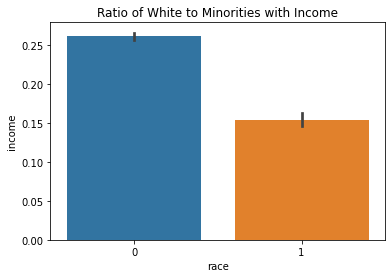

In [ ]:
sns.barplot(x=df_final['race'],
            y=df['income'],
            data=df_final)

plt.title('Ratio of White to Minorities with Income')
plt.show()

This shows that, on avg, white people make around 10 percentage points more money than minorities. 

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


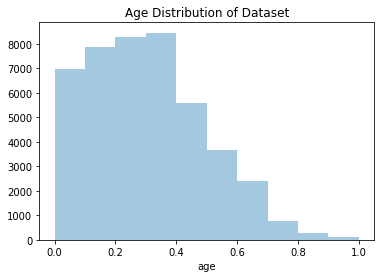

In [ ]:
sns.distplot(df['age'], kde=False, bins=10)
plt.title('Age Distribution of Dataset')
plt.show()

Most of the people who participated are under 40 years old, which somewhat explains the difference in number between the under/over $50k 

In [ ]:
#@title Completed the exercise? 
#@markdown Click on the arrow to the left to create the response form.

import sys
if 'exercise_report_response' not in sys.modules:
  print('Please execute the "Getting Started" cell at the beginning of this exercise, then rerun this cell.')
else:
  exercise_report_response.display_form(exercise_report_response.er_question_list)

If this form does not display correctly in Colab, select "Runttime" from the menu at the top, then select "Restart and run all"
Your first name:


Text(value='', placeholder='Enter your first name here')


Your last name:


Text(value='', placeholder='Enter your last name here')


How difficult was the exercise?


ToggleButtons(button_style='warning', index=2, options=('Very Easy', 'Somewhat Easy', 'Neutral', 'Somewhat Dif…


How long did it take you to complete the exercise?


ToggleButtons(button_style='warning', index=2, options=('30 min or less', '31-60 min', '61-90 min', '91-120 mi…


What tools (or concepts) used in this exercise do you feel confident with?


Textarea(value='', placeholder='Enter your response here')


What tools (or concepts) do you still need practice with?


Textarea(value='', placeholder='Enter your response here')


What suggestions do you have for improving the exercise?


Textarea(value='', placeholder='Enter your response here')


What corrections should be made (typos. etc)?


Textarea(value='', placeholder='Enter your response here')


Share your notebook.
Select 'Share' at the top of the screen. Then select 'Get Link'.
Change the Link so anyone can view it.
Click 'Copy Link', then 'Done'. Paste the link here.


Textarea(value='', placeholder='Enter your response here')

In [ ]:
#@title Ready to Submit?
#@markdown If you have completed the exercise and the exercise response:
#@markdown * check the box 'Ready' box below 
#@markdown * execute this cell

Ready = True #@param {type:"boolean"}

try:
  if Ready == True:
    exercise_report_response.submit_exercise_response(exercise_name, exercise_report_response.er_question_list)

  else:
    print('NOT SUBMITTED!!!')
    print('Check the ready box if you are ready to submit your response.')

except:
  print('NOT SUBMITTED!!!')
  print('Execute the cell above to create the form.')

Exercise response submitted.
